In [1]:
!pip install alpha_vantage pandas matplotlib numpy


In [15]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import time

# i am using my API key here
api_key = "YOUR_ALPHA_VANTAGE_API_KEY"

#these are the  List of stocks
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

#for Creating empty DataFrame
data = pd.DataFrame()

# Fetch stock data one by one
ts = TimeSeries(key=api_key, output_format="pandas")

for ticker in tickers:
    try:
        stock_data, meta_data = ts.get_daily(symbol=ticker, outputsize="compact")
        data[ticker] = stock_data["4. close"]
        print(f"Downloaded {ticker}")
        time.sleep(15)  # Alpha Vantage allows only 5 requests per minute
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

#code for rversing the order  (newest date on top)
data = data.iloc[::-1]

# now we are going Save data to CSV
data.to_csv("stock_data.csv")

print("✅ Stock data saved successfully!")


Downloaded AAPL
Downloaded MSFT
Downloaded GOOGL
Downloaded AMZN
Downloaded TSLA
✅ Stock data saved successfully!


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#we are  Loading stock data from CSV
data = pd.read_csv("stock_data.csv", index_col=0, parse_dates=True)

# code for Calculating daily percentage returns
returns = data.pct_change().dropna()

#we are going to display the first 5 rows
returns.head()


C:\Users\DINO\AppData\Local\Temp\ipykernel_18800\1414793359.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


,AAPL,MSFT,GOOGL,AMZN,TSLA
date,,,,,
2024-10-03,-0.004895,-0.001414,0.000000,-0.015155,-0.033572
2024-10-04,0.005007,-0.001152,0.007235,0.025005,0.039142
2024-10-07,-0.022531,-0.015671,-0.024422,-0.030615,-0.036988
2024-10-08,0.018404,0.012624,0.008590,0.010619,0.015239
2024-10-09,0.016698,0.006631,-0.015330,0.013408,-0.014110


In [19]:
#we have to find the average daily return for each stock
mean_returns = returns.mean()

# Find the covariance matrix (risk)
cov_matrix = returns.cov()


print("Mean Returns:\n", mean_returns)
print("\nCovariance Matrix:\n", cov_matrix)


Mean Returns:
 AAPL     0.000682
MSFT    -0.000371
GOOGL    0.000595
AMZN     0.001657
TSLA     0.002567
dtype: float64

Covariance Matrix:
            AAPL      MSFT     GOOGL      AMZN      TSLA
AAPL   0.000190  0.000083  0.000066  0.000078  0.000141
MSFT   0.000083  0.000210  0.000106  0.000167  0.000185
GOOGL  0.000066  0.000106  0.000373  0.000203  0.000382
AMZN   0.000078  0.000167  0.000203  0.000314  0.000290
TSLA   0.000141  0.000185  0.000382  0.000290  0.002098


In [11]:
# Number of stocks
num_assets = len(data.columns)

# we are defining the function to calculate risk (portfolio variance)
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights  # w^T * Sigma * w

# Constraints: Weights must sum to 1 (100% of money invested)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: No short selling (weights must be between 0 and 1)
bounds = [(0, 1) for _ in range(num_assets)]

# Start with equal investment in all stocks
init_guess = np.ones(num_assets) / num_assets

# Optimize (Minimize Risk)
opt_result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), 
                      method='SLSQP', constraints=constraints, bounds=bounds)

# Get the best allocation
optimal_weights = opt_result.x


print("\nOptimal Portfolio Allocation:")
for i, stock in enumerate(data.columns):
    print(f"{stock}: {optimal_weights[i]*100:.2f}%")



Optimal Portfolio Allocation:
AAPL: 20.00%
MSFT: 20.00%
GOOGL: 20.00%
AMZN: 20.00%
TSLA: 20.00%


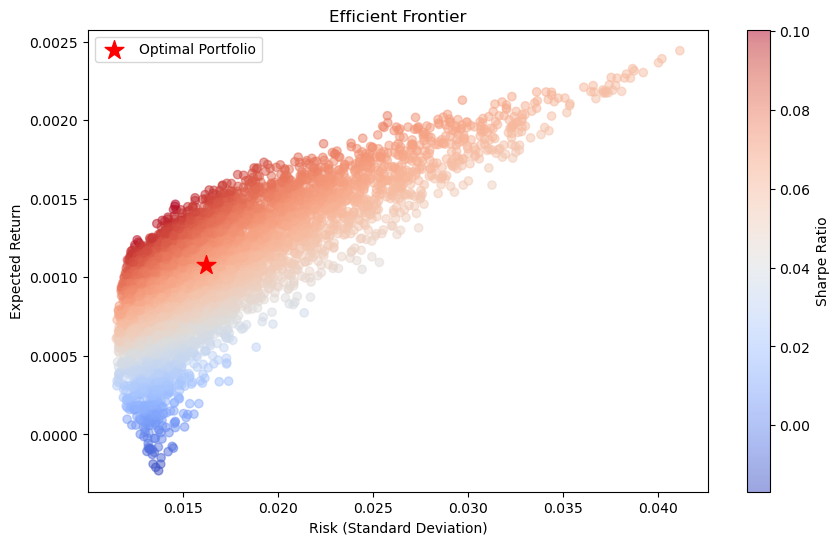

In [13]:
# Generate 5000 random portfolios
num_portfolios = 5000
all_weights = np.random.dirichlet(np.ones(num_assets), num_portfolios)
all_returns = np.dot(all_weights, mean_returns)
all_risks = np.array([np.sqrt(w @ cov_matrix @ w) for w in all_weights])

# Plot Efficient Frontier
plt.figure(figsize=(10,6))
plt.scatter(all_risks, all_returns, c=all_returns/all_risks, cmap="coolwarm", alpha=0.5)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

# Show the optimal portfolio (red star)
opt_risk = np.sqrt(optimal_weights @ cov_matrix @ optimal_weights)
opt_return = np.dot(optimal_weights, mean_returns)
plt.scatter(opt_risk, opt_return, color='red', marker='*', s=200, label="Optimal Portfolio")

plt.legend()
plt.show()
